# **Addestramento di una rete neurale Faster R-CNN per la detection di luoghi ad alto valore culturale**

## Librerie


Librerie da importare:

In [1]:
# Core libraries
import os
import re
import glob
import numpy as np
import random
import xml.etree.ElementTree as ET

# PyTorch
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
import torchvision.transforms as T

# Opencv
import cv2 as cv
from google.colab.patches import cv2_imshow

## Dataset

Sono stati individuati **24 punti di interesse** suddivisi in altrettante directories. 



Ogni punto di interesse contiene, a sua volta, altre tre directory:
- *imgs*: contiene le immagini di dimensione 900 x 1300;
- *annotations*: contiene le annotazioni (coordinate delle bounding box) di ogni immagine catturata;
- *bounding_box*: contiene le immagini con le bouding box individuate.


Il dataset è consultabile al seguente [link](https://drive.google.com/drive/folders/1MenVMP6C9Vuo7JJ-iesAd1KfsemAvSLy?usp=sharing)

### Connessione a Google Drive

Connessione a google drive per scaricare il dataset.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

path = "gdrive/MyDrive/DataSet/DatasetMonuments/"   # Replace with your path

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


### Caricamento del dataset

La funzione *get_bounding_boxes* permette di ottenere le coordinate di tutte le bouding boxes di uno specifico file .xml dato in input.

In [3]:
def get_bounding_boxes(file_xml):
  r"""
  Get all bounding boxes of a specific file xml.
  :param file_xml: file from which to get bounding boxes
  """

  bounding_box_list = []
  labels = []

  tree = ET.parse(file_xml)
  root = tree.getroot()

  # Get all bounding boxes
  j = 6
  while True:
      try:
          object = root[j]

          labels.append(object[0].text)

          box = object[4]
          x_min, y_min, x_max, y_max = int(box[0].text), int(box[1].text), int(box[2].text), int(box[3].text)
          bounding_box_list.append([[x_min, y_min], [x_max, y_max]])

          j += 1
          
      except:
          break

  return bounding_box_list, labels

La funzione *get_transform* applica delle trasformazioni ai dati prima di darli in input alla rete.

In [4]:
def get_transform(train):
  r"""
  Apply the transformations.
  :param: true if it is need to apply the horizontal flip, false otherwise.
  """

  transforms = []
  transforms.append(T.ToTensor())

  if train:
      transforms.append(T.RandomHorizontalFlip(0.5))

  return T.Compose(transforms)

Per ogni etichetta, verrà creata un'istanza della classe *DatasetCulturalHeritage*

In [13]:
class DatasetCulturalHeritage(Dataset):
  r"""
  Class to load the dataset of a specific label.
  """

  def __init__(self, label, label_ds, dir, transforms=None, height=224, width=224):
      r"""
      Load the dataset.
      :param label: label of the dataset.
      :param label_ds: label of the dataset not formatted. 
      :param dir: directory of the monumnet/place.
      :param transform: transform to apply to the data.
      """

      self.label_name   = label
      self.label_ds     = label_ds
      self.img_list     = glob.glob(dir + self.label_ds + '/imgs/*.JPG') + glob.glob(dir + self.label_ds + '/imgs/*.jpg')
      self.annotation_list    = glob.glob(dir + self.label_ds + '/annotations/*.xml')

      self.img_list.sort()
      self.annotation_list.sort()

      self.transforms = transforms
      self.height = height
      self.width = width

      print(f"Classe [{self.label_name}] caricata!\n")
    
  def __getitem__(self, index):
      r"""
      Get the image and its bouding boxes.
      :param index: index of the specific image
      """
      global total_labels

      img_path, annotations_path = self.img_list[index], self.annotation_list[index]

      img = cv.imread(img_path)
      img = cv.cvtColor(img, cv.COLOR_RGB2BGR).astype(np.float32)
      img = cv.resize(img, (self.width, self.height), cv.INTER_AREA)
      img /= 255.0

      bounding_boxes = []
      labels = []
      _boxes, _labels = get_bounding_boxes(annotations_path)

      for box, label in zip(_boxes, _labels):

        labels.append(total_labels.index(label))

        x_min = box[0][0]
        x_max = box[1][0]
        y_min = box[0][1]
        y_max = box[1][1]

        bounding_boxes.append([x_min, y_min, x_max, y_max])
      
      # Bouding boxes
      bounding_boxes = torch.as_tensor(bounding_boxes, dtype=torch.float32)

      # Labels
      labels = torch.as_tensor(labels, dtype=torch.int64)

      # Area
      area = (bounding_boxes[:, 3] - bounding_boxes[:, 1]) * \
              (bounding_boxes[:, 2] - bounding_boxes[:, 0])

      # Id
      img_id = torch.tensor([index])

      is_crowd = torch.zeros((len(bounding_boxes),), dtype=torch.int64)

      target = {}
      target["boxes"] = bounding_boxes
      target["labels"] = labels
      target["image_id"] = img_id
      target["area"] = area
      target["is_crowd"] = is_crowd

      if self.transforms is not None:
        img, target = self.transforms(img, target)

      return img, target

  def length(self):
      return len(self.img_list), len(self.annotation_list)

  def __len__(self):
      assert len(self.img_list) == len(self.annotation_list)

      return len(self.img_list)

La funzione *split_directory* permette di formattare il testo dato in input sulla base delle lettere maiuscole.

In [6]:
def split_directory(title):
    r"""
    Split text of the directory
    :param title: text to split
    :return: text with the tabulations
    """
    
    title = title[0].upper() + title[1:]
    folder = re.findall('[A-Z][^A-Z]*', title)
    result = ""

    for i, item in enumerate(folder):
        result += str(item) + (" " if (i + 1) != len(folder) else "")

    return result

Caricamento del dataset.

In [14]:
dataset = []
num_imgs = 0
num_annotations = 0
total_labels = []

print("Caricamento dataset in corso ...\n\n")

dirs = os.listdir(path)
for index, dir in enumerate(dirs):

  name_class = split_directory(dir)

  class_label = DatasetCulturalHeritage(name_class, dir, path)  # TODO valutare la trasformazione
  _num_imgs, _num_annotations = class_label.length()

  num_imgs += _num_imgs
  num_annotations += _num_annotations
  total_labels.append(name_class)

  dataset.append(class_label)

print("Caricamento terminato.")

Caricamento dataset in corso ...


Classe [Villino Ruggeri] caricata!

Classe [Statua Gioachino Rossini] caricata!

Classe [Scultura Della Memoria] caricata!

Classe [Rocca Costanza] caricata!

Classe [Portale San Domenico] caricata!

Classe [Teatro Rossini] caricata!

Classe [Statua Giulio Perticari] caricata!

Classe [Statua Giuseppe Garibaldi] caricata!

Classe [Teatro Sperimentale] caricata!

Classe [Villa Caprile] caricata!

Classe [Palla Di Pomodoro] caricata!

Classe [Palazzo Ducale] caricata!

Classe [Parrocchia Santa Maria] caricata!

Classe [Palazzo Comunale] caricata!

Classe [Palazzo Delle Poste] caricata!

Classe [Palazzo Olivieri] caricata!

Classe [Chiesa San Agostino] caricata!

Classe [Fontana Piazza] caricata!

Classe [Centro Arti Visive] caricata!

Classe [Palazzo Baviera] caricata!

Classe [Arco Di Trionfo] caricata!

Classe [Casa Rossini] caricata!

Classe [Berlina Mosca] caricata!

Classe [Cattedrale Santa Maria Assunta] caricata!

Classe [Free] caricata!

Caricam

In [67]:
print(f"Numero totale di immagini: {num_imgs}\n")
print(f"Numero totale di annotazioni: {num_annotations}", end="\n\n")
print(f"Numero totale di classi: {total_labels}")

Numero totale di immagini: 953

Numero totale di annotazioni: 953

Numero totale di classi: 25


### Visualizzazione del dataset

La funzione *stack_images* permette di mostrare una lista orizzontale e/o verticale di immagini.

In [56]:
def stack_images(scale, img_array):
    r"""
    Stack the images based on the number of them by rows and columns.
    Resize the images.
    :param scale: scale factor.
    :param img_array: array of images.
    :return: array of images to show.
    """

    rows = len(img_array)
    cols = len(img_array[0])

    rowsAvailable = isinstance(img_array[0], list)

    width = img_array[0][0].shape[1]
    height = img_array[0][0].shape[0]

    if rowsAvailable:
        for x in range(0, rows):
            for y in range(0, cols):

                if img_array[x][y].shape[:2] == img_array[0][0].shape[:2]:
                    img_array[x][y] = cv.resize(img_array[x][y], (0, 0), None, scale, scale)
                else:
                    img_array[x][y] = cv.resize(img_array[x][y], (img_array[0][0].shape[1], img_array[0][0].shape[0]),
                                                None, scale, scale)

                if len(img_array[x][y].shape) == 2:
                    img_array[x][y] = cv.cvtColor(img_array[x][y], cv.COLOR_GRAY2BGR)

        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank] * rows

        for x in range(0, rows):
            hor[x] = np.hstack(img_array[x])
        ver = np.vstack(hor)

    else:
        for x in range(0, rows):

            if img_array[x].shape[:2] == img_array[0].shape[:2]:
                img_array[x] = cv.resize(img_array[x], (0, 0), None, scale, scale)
            else:
                img_array[x] = cv.resize(img_array[x], (img_array[0].shape[1], img_array[0].shape[0]), None, scale,
                                         scale)

            if len(img_array[x].shape) == 2:
                img_array[x] = cv.cvtColor(img_array[x], cv.COLOR_GRAY2BGR)

        hor = np.hstack(img_array)
        ver = hor

    return ver


Visualizzazione casuale di alcune immagini del dataset caricato.

La funzione *draw_description* disegna il nome della classe in basso nell'immagine.

In [57]:
def draw_description(img, text):
    r"""
    Draw description image.
    :param text: image description
    :param img: image in which to insert the descrition
    :return: image with description
    """

    bottom = int(0.04 * img.shape[0])
    img = cv.copyMakeBorder(img, 0, bottom, 0, 0, cv.BORDER_CONSTANT, None, (255, 255, 255))

    height, _, _ = img.shape
    cv.putText(img, text, (0, height - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    
    return img

La funzione *convert_point_to_tuple* converte una coordinata (punto x,y) in una tupla.

In [58]:
def convert_point_to_tuple(point):
    x, y = point
    return (x,y)

Il codice seguente mostra una griglia di 4 immagini casuali prese dal dataset. Per ogni immagine, a sinistra, viene mostrata quella originale e a destra la stessa immagine con le bounding box individuate.

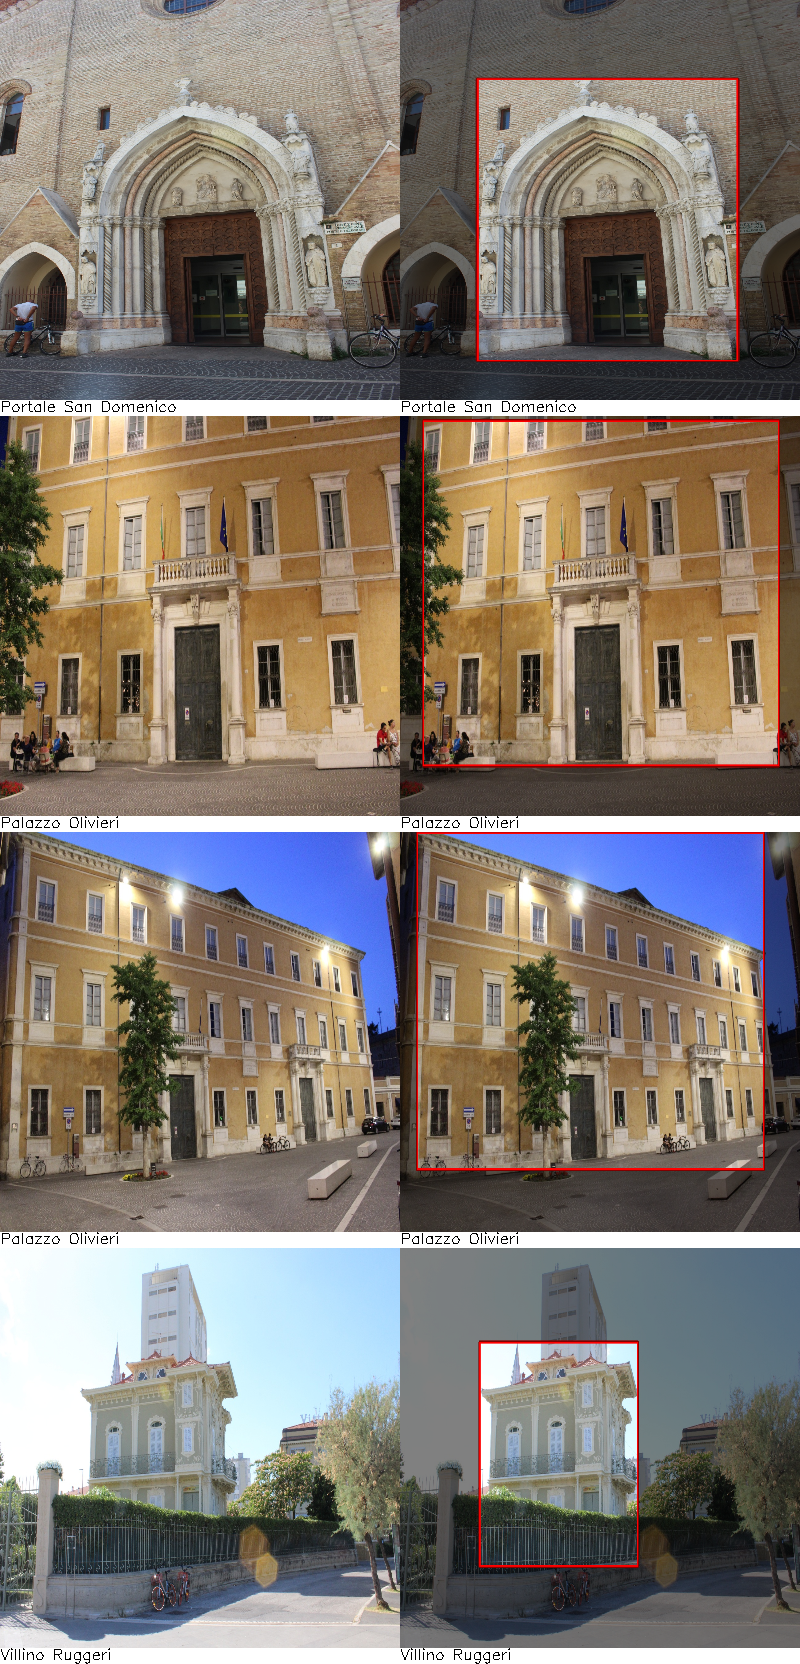

In [59]:
labels_to_show = []       # Labels of the images to show
bounding_box_list = []    # List of the boudning boxes drawed.
imgs_read_list = []       # List of the images read (no trasformations)
imgs_list = []            # List of the images trasformated (with bouding boxes)
title_images_list = []    # Label formattated.

labels_to_show.append(random.randint(0, len(dirs) - 1))
labels_to_show.append(random.randint(0, len(dirs) - 1))
labels_to_show.append(random.randint(0, len(dirs) - 1))
labels_to_show.append(random.randint(0, len(dirs) - 1))

for i in range(0, 4):
    alpha = 0.5
    bounding_box_list.clear()

    index_label = labels_to_show[i]
    class_label = dataset[index_label]

    imgs = class_label.img_list
    annotations = class_label.annotation_list
    label = class_label.label_ds

    index_img = random.randint(0, len(imgs) - 1)

    # Parse xml
    tree = ET.parse(annotations[index_img])
    root = tree.getroot()

    # Get bounding boxes
    bounding_box_list = get_bounding_boxes(annotations[index_img])

    # Image
    img_read = cv.imread(imgs[index_img])
    img_read = cv.cvtColor(img_read, cv2.COLOR_RGB2BGR)

    img_original = cv.resize(img_read, (400,400))
    imgs_read_list.append(img_original)

    # Mask
    mask = np.zeros_like(img_read[:, :, 0])

    for j, box in enumerate(bounding_box_list):
        # Draw rectangle
        cv.rectangle(img_read, convert_point_to_tuple(box[0]), convert_point_to_tuple(box[1]), (0, 0, 255), 5)

        polygon = np.array([[bounding_box_list[j][0]], [[bounding_box_list[j][1][0],
                            bounding_box_list[j][0][1]]], [bounding_box_list[j][1]],
                            [[bounding_box_list[j][0][0], bounding_box_list[j][1][1]]]])
        
        cv.fillConvexPoly(mask, polygon, 1)

    # Get polygon
    img = cv.bitwise_and(img_read, img_read, mask=mask)
    img = cv.addWeighted(img_read.copy(), alpha, img, 1 - alpha, 0)
    img = cv.resize(img, (400, 400))
    imgs_list.append(img)

    title_images_list.append(class_label.label_name)


imgs_stack = stack_images(1, ([draw_description(imgs_read_list[0], title_images_list[0]), draw_description(imgs_list[0], title_images_list[0])],
                              [draw_description(imgs_read_list[1], title_images_list[1]), draw_description(imgs_list[1], title_images_list[1])],
                              [draw_description(imgs_read_list[2], title_images_list[2]), draw_description(imgs_list[2], title_images_list[2])],
                              [draw_description(imgs_read_list[3], title_images_list[3]), draw_description(imgs_list[3], title_images_list[3])]))

cv2_imshow(imgs_stack)

### Trainining, validation e test set

La funzione *train_test_split* suddivide il dataset in training, validation e test set rispettivamente al 70% (training), 20% (validation) e 10% (test).

In [60]:
def train_test_split(dataset):
    r"""
    Slip dataset in training, validation and test set:
        - 70% training set;
        - 20% validation set:
        - 10% test set.

    :param dataset: dataset to split
    :return : training, validation and test set.
    """
    length_dataset = len(dataset)

    length_train = np.int_(length_dataset * 0.7)
    length_validate = np.int_(length_dataset * 0.2)

    training_dataset = Subset(dataset, range(0, length_train))
    validation_dataset = Subset(dataset, range(length_train, length_train + length_validate))
    test_dataset = Subset(dataset, range(length_train + length_validate, len(dataset)))

    return training_dataset, validation_dataset, test_dataset

Partizionamento dataset.

In [61]:
trainining_set = []
validation_set = []
test_set = []

for _set in dataset:
    
    training_dataset, validation_dataset, test_dataset = train_test_split(_set)

    trainining_set.append(training_dataset)
    validation_set.append(validation_dataset)
    test_set.append(test_dataset)


training_dataset, validation_dataset, test_dataset = ConcatDataset(trainining_set), ConcatDataset(validation_set), \
                                                     ConcatDataset(test_set)

print(f"** Dataset caricato correttamente! Totale immagini: {len(training_dataset) + len(validation_dataset) + len(test_dataset)} **\n")
print(f"Dimensione training: {len(training_dataset)} immagini - (70%)")
print(f"Dimensione validation: {len(validation_dataset)} immagini - (20%)")
print(f"Dimensione test: {len(test_dataset)} immagini - (10%)\n\n")
print(f"Totale immagini partizionate: {len(training_dataset) + len(validation_dataset) + len(test_dataset)}\n\n")

** Dataset caricato correttamente! Totale immagini: 953 **

Dimensione training: 657 immagini - (70%)
Dimensione validation: 181 immagini - (20%)
Dimensione test: 115 immagini - (10%)


Totale immagini partizionate: 953




Creazione dei *DataLoader* rispettivamente per training, validation e test set.

In [62]:
# TODO valutare il numero di batch_size e num_workers

batch_size = 8

# Training set
training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=False)

# Validation set
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Test set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Modello della rete

Definizione del modello pre-addestrato Faster R-CNN.

In [68]:
# Load the model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Classes
num_classes = total_labels + 1  # N classes + background

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

26


Modifica del modello aggiungendo una specifica backbone.

In [64]:
# TODO continuare da qui (verificare se servono tutte le proprietà settate)
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Inizializzazione del modello

In [65]:
# Model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Runtime: {device}")
model = model.to(device)

Runtime: cuda


## Addestramento

## Risultati ottenuti

Dubbi / problemi:

- Ripartire dal TODO nella definizione del modello
- Valutare il numero di batch_size e num_worker, prima di addestrare
- Non funziona il caricamento del dataset se applico la trasformazione (attenzione qualcuno applica la trasformazione solo per training e validation)


- --> Guardare link nel file link <--